# **Pirate Pain Challenge - Bidirectional Recurrent Neural Network**
![image.png](images/brnn.png)
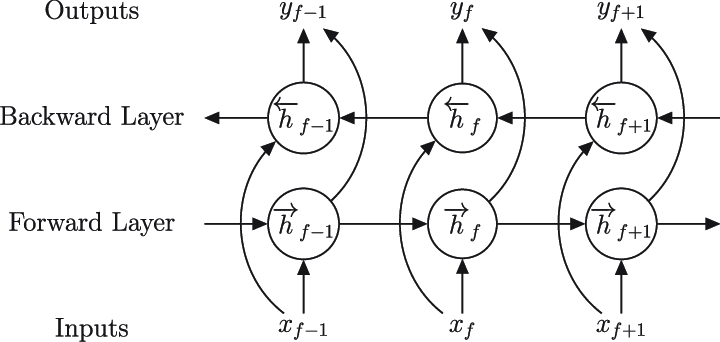
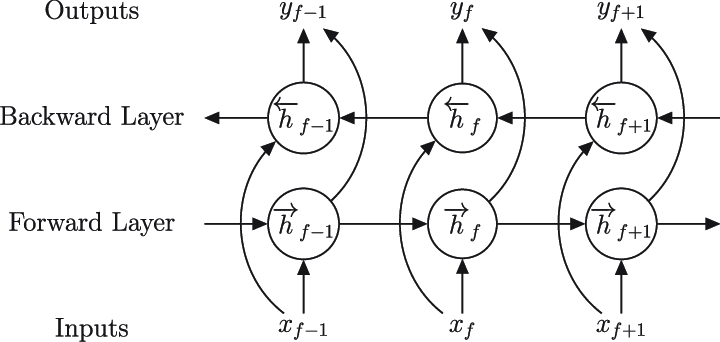

## 🌐 **Google Drive Connection or local mount**

In [181]:
import os

isColab = False

try:
    from google.colab import drive

    drive.mount("/gdrive")
    current_dir = "/gdrive/My\\ Drive/Colab\\ Notebooks/[2025-2026]\\ AN2DL/AN2DL-challenge-1"
    print("Running in Google Colab. Google Drive mounted.")
    %cd $current_dir
    isColab = True
except ImportError:
    print("Running in a local environment. Skipping Google Drive mount.")
    current_dir = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1"
    if not os.path.isdir(current_dir):
        current_dir = os.getcwd()
    print(f"Current directory set to: {current_dir}")
if not isColab:
    os.chdir(current_dir)
print(f"Changed directory to: {current_dir}")

Running in a local environment. Skipping Google Drive mount.
Current directory set to: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1
Changed directory to: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1


## ⚙️ **Libraries Import**

In [182]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch

torch.manual_seed(SEED)
# from torchsummary import summary

logs_dir = "tensorboard"
if isColab:
    !pkill -f tensorboard
else:
    # Arresta eventuali processi tensorboard in locale (Windows)
    import os
    if os.name == 'nt':
        try:
            import psutil
            for proc in psutil.process_iter(['name', 'cmdline']):
                name = (proc.info.get('name') or '').lower()
                cmd = ' '.join(proc.info.get('cmdline') or []).lower()
                if 'tensorboard' in name or 'tensorboard' in cmd:
                    try:
                        proc.kill()
                    except Exception:
                        pass
        except ImportError:
            import subprocess
            subprocess.run(['taskkill', '/F', '/IM', 'tensorboard.exe'],
                           stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

%load_ext tensorboard
if isColab:
    !mkdir -p models
else:
    os.makedirs("models", exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu130
Device: cuda


## ⏳ **Data Downloading**

In [183]:
import os
import zipfile

# --- 1. Impostazioni ---
competition_name = 'an2dl2526c1'
dataset_path = 'dataset'
train_file = 'pirate_pain_train.csv'
test_file = 'pirate_pain_test.csv'
labels_file = 'pirate_pain_train_labels.csv'
sample_submission_file = 'sample_submission.csv'

# Controlla se il dataset è già stato scaricato ed estratto
if not os.path.exists(os.path.join(dataset_path, train_file)):
    # --- 2. Autenticazione e Download ---
    from kaggle.api.kaggle_api_extended import KaggleApi
    # Inizializza l'API di Kaggle
    # L'autenticazione avviene automaticamente se 'kaggle.json' è in C:\\Users\\Bert0ns\\.kaggle\\
    api = KaggleApi()
    api.authenticate()

    print(f"Download del dataset dalla competizione '{competition_name}'...")

    # Crea la directory di destinazione se non esiste
    os.makedirs(dataset_path, exist_ok=True)

    # Scarica i file della competizione nella cartella 'dataset'
    api.competition_download_files(competition_name, path=dataset_path)

    # Estrai i file dall'archivio zip
    zip_path = os.path.join(dataset_path, f'{competition_name}.zip')
    if os.path.exists(zip_path):
        print(f"Estrazione dei file da '{zip_path}'...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_path)
        # Rimuovi il file zip dopo l'estrazione
        os.remove(zip_path)
        print("Estrazione completata e file zip rimosso.")
    else:
        print("ATTENZIONE: File zip non trovato. Il download potrebbe non essere riuscito.")
else:
    print("Il dataset è già presente nella cartella 'dataset'. Download saltato.")


Il dataset è già presente nella cartella 'dataset'. Download saltato.


## 🔎 **Exploration and Data Analysis**

In [184]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv(os.path.join(dataset_path, train_file))
kaggle_test_df = pd.read_csv(os.path.join(dataset_path, test_file))
labels_df = pd.read_csv(os.path.join(dataset_path, labels_file))
sample_submission_df = pd.read_csv(os.path.join(dataset_path, sample_submission_file))

**Convert data to a memory efficient form**

In [185]:
na_value = -1
text_map = {
    'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
    'unknown': na_value, 'nan': na_value, 'none': na_value, 'n/a': na_value,
    'one+peg_leg': 1, 'one+hook_hand': 1, 'one+eye_patch': 1,
    'no_pain': 0, 'low_pain': 1, 'high_pain': 2
}

# Pulisce, normalizza, mappa; fallback a numerico e a cifre estratte
columns_to_convert = ['n_legs', 'n_hands', 'n_eyes']
for col in columns_to_convert:
    train_df[col] = train_df[col].str.strip().str.lower().map(text_map).astype('int8')
    kaggle_test_df[col] = kaggle_test_df[col].str.strip().str.lower().map(text_map).astype('int8')

# train_df.head(105760)

In [186]:
# Convert data types from float64 to float32 to save memory
train_df[train_df.select_dtypes(include=['float64']).columns] = train_df.select_dtypes(include=['float64']).astype(
    'float32')
kaggle_test_df[kaggle_test_df.select_dtypes(include=['float64']).columns] = kaggle_test_df.select_dtypes(
    include=['float64']).astype(
    'float32')

# Convert int64 to int32
train_df[train_df.select_dtypes(include=['int64']).columns] = train_df.select_dtypes(include=['int64']).astype('int32')
kaggle_test_df[kaggle_test_df.select_dtypes(include=['int64']).columns] = kaggle_test_df.select_dtypes(
    include=['int64']).astype('int32')
labels_df[labels_df.select_dtypes(include=['int64']).columns] = labels_df.select_dtypes(include=['int64']).astype(
    'int32')

# Convert pain surveys to int8
train_df['pain_survey_1'] = train_df['pain_survey_1'].astype('int8')
train_df['pain_survey_2'] = train_df['pain_survey_2'].astype('int8')
train_df['pain_survey_3'] = train_df['pain_survey_3'].astype('int8')
train_df['pain_survey_4'] = train_df['pain_survey_4'].astype('int8')

kaggle_test_df['pain_survey_1'] = kaggle_test_df['pain_survey_1'].astype('int8')
kaggle_test_df['pain_survey_2'] = kaggle_test_df['pain_survey_2'].astype('int8')
kaggle_test_df['pain_survey_3'] = kaggle_test_df['pain_survey_3'].astype('int8')
kaggle_test_df['pain_survey_4'] = kaggle_test_df['pain_survey_4'].astype('int8')

# Convert labels sample_index to int8
labels_df['label'] = labels_df['label'].str.strip().str.lower().map(text_map).astype('int8')

## 🔄 **Data Preprocessing**

#### Split train_df in train, validation, test sub-datasets

In [187]:
VALIDATION_SET_PERCENTAGE = 0.15
TEST_SET_PERCENTAGE = 0.15

unique_samples = train_df['sample_index'].unique()
random.seed(SEED)
np.random.shuffle(unique_samples)

N_VAL_SAMPLES = int(VALIDATION_SET_PERCENTAGE * len(unique_samples))
N_TEST_SAMPLES = int(TEST_SET_PERCENTAGE * len(unique_samples))
N_TRAIN_SAMPLES = len(unique_samples) - N_VAL_SAMPLES - N_TEST_SAMPLES

# split indexes
train_samples = unique_samples[:N_TRAIN_SAMPLES]
val_samples = unique_samples[N_TRAIN_SAMPLES:N_TRAIN_SAMPLES + N_VAL_SAMPLES]
test_samples = unique_samples[N_TRAIN_SAMPLES + N_VAL_SAMPLES:]

# split
df_train = train_df[train_df['sample_index'].isin(train_samples)]
df_test = train_df[train_df['sample_index'].isin(test_samples)]
df_val = train_df[train_df['sample_index'].isin(val_samples)]

print(f"Train samples: {df_train.shape}")
print(f"Validation samples: {df_val.shape}")
print(f"Test samples: {df_test.shape}")

Train samples: (74080, 40)
Validation samples: (15840, 40)
Test samples: (15840, 40)


In [188]:
# @title Normalize data: MinMaxScaler
# Normalize all features to [0, 1] range using MinMaxScaler, features excluded: [sample_index, time]
from sklearn.preprocessing import MinMaxScaler

joint_columns = [f'joint_{i:02d}' for i in range(31)]

scale_columns = joint_columns + ['n_legs', 'n_hands', 'n_eyes', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3',
                                 'pain_survey_4']

scaler = MinMaxScaler()

df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
df_val[scale_columns] = scaler.transform(df_val[scale_columns])
df_test[scale_columns] = scaler.transform(df_test[scale_columns])

# Normalize also the kaggle test set
kaggle_test_df[scale_columns] = scaler.transform(kaggle_test_df[scale_columns])

#### Remove useless features

In [189]:
# @title Remove feature from joint_13 to joint_25 + joint_30
columns_to_remove = [f'joint_{i:02d}' for i in range(13, 26)] + ['joint_30']

df_train_reduced = df_train.drop(columns=columns_to_remove, inplace=False)
df_test_reduced = df_test.drop(columns=columns_to_remove, inplace=False)
df_val_reduced = df_val.drop(columns=columns_to_remove, inplace=False)

kaggle_test_df_reduced = kaggle_test_df.drop(columns=columns_to_remove, inplace=False)

#### Build sequences with sliding window

In [190]:
# Define the window size
WINDOW_SIZE = 200

# Define the stride for overlapping windows
STRIDE = 50

In [191]:
# Define a function to build sequences from the dataset
def build_sequences(df, label_df, scale_columns, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp = df[df['sample_index'] == id][scale_columns].values

        # Retrieve the activity label for the current ID
        label = label_df[label_df['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, 24), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [192]:
value_cols = [col for col in scale_columns if col not in columns_to_remove]

X_train, y_train = build_sequences(df_train_reduced, labels_df, value_cols, window=WINDOW_SIZE, stride=STRIDE)
X_val, y_val = build_sequences(df_val_reduced, labels_df, value_cols, window=WINDOW_SIZE, stride=STRIDE)
X_test, y_test = build_sequences(df_test_reduced, labels_df, value_cols, window=WINDOW_SIZE, stride=STRIDE)

print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")

Train set: X=(463, 200, 24), y=(463,)
Validation set: X=(99, 200, 24), y=(99,)
Test set: X=(99, 200, 24), y=(99,)


#### Convert data sets in TensorDatasets

In [193]:
from torch.utils.data import TensorDataset

# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val).long())
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())

In [194]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 256

In [195]:
from torch.utils.data import DataLoader


def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [196]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [197]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break  # Stop after getting one batch

Features batch shape: torch.Size([256, 200, 24])
Labels batch shape: torch.Size([256])


In [198]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

## 🛠️ **Model Building**